In [1]:
%matplotlib inline

In [2]:
import numpy as np
import random  as rd
from numba import jit
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
import math
import random

In [3]:
G = 6.67408e-11 # m**3 kg**-1 s**-2 ----- Gravitational constant
nParticles = 50
nStars = 2
planetmass = 5.96e26
nt_simulation = 240

# =======================================================================
# -----------------------------Positions---------------------------------
# =======================================================================

if nStars == 1:
    init_particle_x = np.hstack(([0], (np.random.normal(0,1,nParticles))*1.5e12))
    init_particle_y = np.hstack(([0], (np.random.normal(0,1,nParticles))*1.5e12))
if nStars == 2:
    init_particle_x = np.hstack(([1.5e11*4], [-1.5e11*4],
                                 (np.random.normal(0,1,nParticles))*1.5e12*.5))
    init_particle_y = np.hstack(([0], [0], (np.random.normal(0,1,nParticles))*1.5e12*.5))

init_particle = np.vstack((init_particle_x,init_particle_y)).T
# print "init_particle:\n", init_particle

particlem = np.hstack(([2e30]*nStars, [planetmass]*nParticles))
com = sum([particlem[j]*init_particle_x[j] for j in range(nParticles + nStars)]) / sum(particlem)

# =======================================================================
# ----------------------------Velocities---------------------------------
# =======================================================================

if nStars == 1:
    init_v_x_stars = [0]
    init_v_y_stars = [0]
    init_v_x_planets = [math.copysign(np.sqrt(G * particlem[0] /
                                              np.sqrt(init_particle_x[ii]**2 +
                                                      init_particle_y[ii]**2)) *
                                      np.cos(np.arctan2(init_particle_y[ii],init_particle_x[ii])+(np.pi/2.)),
                                     - init_particle_y[ii])
                        for ii in range(nStars,nStars+nParticles)]
    init_v_y_planets = [math.copysign(np.sqrt(G * particlem[0] /
                                              np.sqrt(init_particle_x[ii]**2 +
                                                      init_particle_y[ii]**2)) *
                                      np.sin(np.arctan2(init_particle_y[ii],init_particle_x[ii])+(np.pi/2.)),
                                     init_particle_x[ii])
                        for ii in range(nStars,nStars+nParticles)]
    init_v_x = init_v_x_stars + init_v_x_planets
    init_v_y = init_v_y_stars + init_v_y_planets
    init_v = np.vstack((init_v_x,init_v_y)).T

if nStars == 2:
    init_v_x_stars = [0 for i in range(nStars)]
    init_v_y_stars = [math.copysign(np.sqrt(G * particlem[0] / (abs(4*init_particle_x[ii]))), 
                              init_particle_x[ii]) for ii in range(nStars)]

    init_v_x_planets = [math.copysign(np.sqrt(G * (particlem[0]+particlem[1]) /
                                              np.sqrt(init_particle_x[ii]**2 +
                                                      init_particle_y[ii]**2)) *
                                      np.cos(np.arctan2(init_particle_y[ii],init_particle_x[ii])+(np.pi/2.)),
                                     - init_particle_y[ii])
                        for ii in range(nStars,nStars+nParticles)]
    init_v_y_planets = [math.copysign(np.sqrt(G * (particlem[0]+particlem[1]) /
                                              np.sqrt(init_particle_x[ii]**2 +
                                                      init_particle_y[ii]**2)) *
                                      np.sin(np.arctan2(init_particle_y[ii],init_particle_x[ii])+(np.pi/2.)),
                                     init_particle_x[ii])
                        for ii in range(nStars,nStars+nParticles)]
    init_v_x = init_v_x_stars + init_v_x_planets
    init_v_y = init_v_y_stars + init_v_y_planets
    init_v = np.vstack((init_v_x,init_v_y)).T

# print "init_v:\n", init_v

#=======================================================================
#--------------------------------Forces---------------------------------
#=======================================================================

def galsim(particle, particlev, particlem, nParticles, nStars):
    dt= 7.5e4
    G = 6.67408e-11
    eps = 5e7
    for i in range(nParticles + nStars):
        Fx = 0.0
        Fy = 0.0
        for j in range(nParticles + nStars):
            if j != i:
                dx = particle[j,0] - particle[i,0]
                dy = particle[j,1] - particle[i,1]
                dr = np.sqrt(dx**2 + dy**2)
                F = - G * particlem[i] * particlem[j] / (dr+eps)**2
                Fx += (math.copysign(F * np.cos(np.arctan(dy / dx)), dx))
                Fy += (math.copysign(F * np.sin(np.arctan(dy / dx)), dy))
        particlev[i, 0] += ((Fx / particlem[i]) * dt)
        particlev[i, 1] += ((Fy / particlem[i]) * dt)
    for i in range(nParticles + nStars):
        particle[i,0] += (particlev[i,0] * dt)
        particle[i,1] += (particlev[i,1] * dt)
    return particle, particlev

# =======================================================================
# -----------------------------Execution---------------------------------
# =======================================================================

init_gal = galsim(init_particle, init_v, particlem, nParticles, nStars)
# print "init:\n", init_gal[0]
#Initializing lists
states = []
x = []
y = []

#Creating lists of the X and Y coordinates of each particle from t=0 to t=nt_simulation
for t in range(nt_simulation):
    gal_data = galsim(init_gal[0],init_gal[1],particlem, nParticles, nStars)
    states.append(gal_data[0])
    current_state = states[t]
    current_copy_x = list(current_state[:,0])
    x.insert(t,current_copy_x)
    current_copy_y = list(current_state[:,1])
    y.insert(t,current_copy_y)
    init_gal = gal_data
    
# =======================================================================
# =======================================================================
# ------------------------------Animation--------------------------------
# =======================================================================
# =======================================================================

planetc1 = np.array([random.uniform(0, 1) for i in range(nParticles+nStars)])
planetc2 = np.array([random.uniform(0, 1) for i in range(nParticles+nStars)])
planetc3 = np.array([random.uniform(0, 1) for i in range(nParticles+nStars)])

def initial():
    particles.set_offsets([])
    return particles,

def animate(i):
    j = 0
    ntrails = 50
    data = np.vstack((x[i], y[i])).T
    while j < i and j < ntrails:
        data = np.vstack((data, np.vstack((x[i-j],y[i-j])).T))
        j += 1
    particles.set_offsets(data)
    
    percentm = np.array([(particlem[i] / sum(particlem)) for i in range(len(particlem))])
    percentm = percentm / percentm.max()*100
    percentm = (np.ceil(percentm)).tolist() * ntrails
    particles.set_sizes(percentm)
    
# =======================================================================
# -------------------------------Colors!---------------------------------
# =======================================================================
    
    from matplotlib import colors
    init_alpha = [[1.]*nStars+[1.]*nParticles][0]
    init_decay = []
    for decay in np.linspace(.25,0.0001,ntrails):
        init_decay += [[decay]*nStars + [decay]*nParticles][0]
    alpha = init_alpha + init_decay
    rgba_colors = np.zeros((len([[0]*nStars+[0]*nParticles][0]*(ntrails+1)),4))
    if nStars == 1:
        rgba_colors[::nParticles+nStars,0] = 240./255.
        rgba_colors[::nParticles+nStars,1] = 128./255.
        rgba_colors[::nParticles+nStars,2] = 128./255.
    if nStars == 2:
        for i in range(2):
            rgba_colors[i::nParticles+nStars,0] = 240./255.
            rgba_colors[i::nParticles+nStars,1] = 128./255.
            rgba_colors[i::nParticles+nStars,2] = 128./255.
    for i in range(nStars,nParticles+nStars):
        rgba_colors[i::nParticles+nStars,0] = planetc1[i]
        rgba_colors[i::nParticles+nStars,1] = planetc2[i]
        rgba_colors[i::nParticles+nStars,2] = planetc3[i]
    for a in range(len(alpha)):
        rgba_colors[a, 3] = alpha[a]
    particles.set_color(rgba_colors)

    return particles,

print "It begins!"

# fig = plt.figure(figsize=(12,12))
# fsize = 5e12
# ax = plt.axes(xlim=(-fsize, fsize), ylim=(-fsize, fsize))
# ax.set_facecolor('whitesmoke')
# ax.minorticks_on()
# ax.tick_params('both', length=8, which='major')
# ax.tick_params('both',length=3, which='minor')
# ax.set_xlabel('')
# ax.set_ylabel('')
# ax.xaxis.set_ticks_position('none')
# ax.yaxis.set_ticks_position('none')
# ax.set_xticklabels([])
# ax.set_yticklabels([])
# ax.grid(True, which='major', ls='dashed', alpha=.5)
# ax.grid(True, which='minor', ls='dashed', alpha=.15)
# particles = ax.scatter([], [], marker='o')
# plt.title('Simulation')

# rc('animation', html='html5')
# anim = animation.FuncAnimation(fig, animate, init_func = initial,
#                                frames=nt_simulation, interval=60, blit=True)
# anim

It begins!


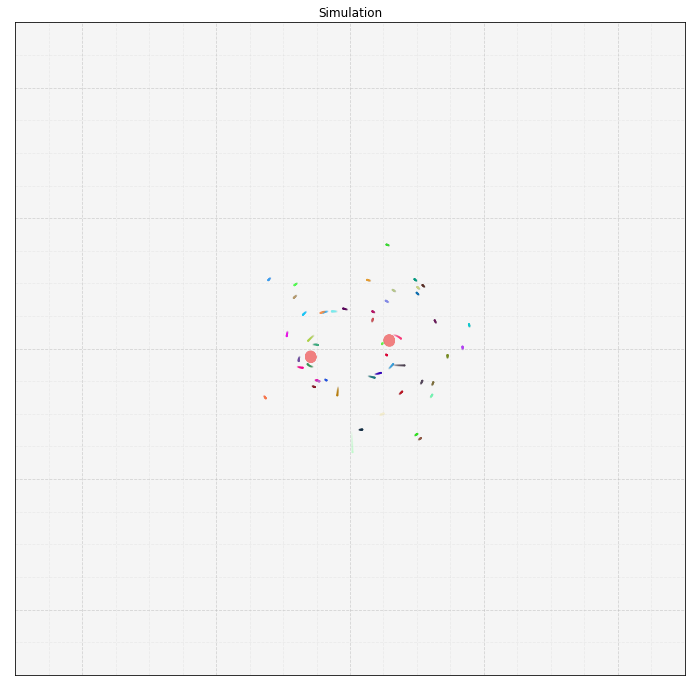

In [4]:
fig = plt.figure(figsize=(12,12))
fsize = 5e12
ax = plt.axes(xlim=(-fsize, fsize), ylim=(-fsize, fsize))
ax.set_facecolor('whitesmoke')
ax.minorticks_on()
ax.tick_params('both', length=8, which='major')
ax.tick_params('both',length=3, which='minor')
ax.set_xlabel('')
ax.set_ylabel('')
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.grid(True, which='major', ls='dashed', alpha=.5)
ax.grid(True, which='minor', ls='dashed', alpha=.15)
particles = ax.scatter([], [], marker='o')
plt.title('Simulation')

rc('animation', html='html5')
anim = animation.FuncAnimation(fig, animate, init_func = initial,
                               frames=nt_simulation, interval=60, blit=True)
anim

In [15]:
from astropy.convolution import convolve, convolve_fft, Gaussian2DKernel

In [16]:
def framer(RA, DEC):

    """
    The Framer gives RA and DEC values to center EOs for plotting.

    Args:

        RA: List of all RA values for an extended object.
        DEC: List of all DEC values for an extended object.

    Returns:

        Minimum and maximum values of RA and DEC to center an EO for plotting.

    """
    min_RA, max_RA, min_DEC, max_DEC = min(RA), max(RA), min(DEC), max(DEC)
    min_degrees = 25
    x = max_RA - min_RA
    y = max_DEC - min_DEC
    z = .05 * max(x, y)
    if (x > y) and (x - y > min_degrees / 3600.):
        RA_zoom_min = min_RA - z
        RA_zoom_max = max_RA + z
        DEC_zoom_min = min_DEC - .5 * (x - y) - z
        DEC_zoom_max = max_DEC + .5 * (x - y) + z
    elif (y > x) and (y - x > min_degrees / 3600.):
        RA_zoom_min = min_RA - .5 * (y - x) - z
        RA_zoom_max = max_RA + .5 * (y - x) + z
        DEC_zoom_min = min_DEC - z
        DEC_zoom_max = max_DEC + z
    else:
        RA_zoom_min = RA[0] - .25
        RA_zoom_max = RA[-1] + .25
        DEC_zoom_min = DEC[0] - .25
        DEC_zoom_max = DEC[-1] + .25
    return {'RA_zoom_min': RA_zoom_min, 'RA_zoom_max': RA_zoom_max,
            'DEC_zoom_min': DEC_zoom_min, 'DEC_zoom_max': DEC_zoom_max}

In [17]:
def pixelate(ra_zoom, dec_zoom, n_bins, ra_total, dec_total, flux_total):

    import numpy as np
    # Check to see which dimension is larger so that
    # a square in RA and DEC can be returned.
    if (ra_zoom[1] - ra_zoom[0]) > (dec_zoom[1] - dec_zoom[0]):
        zoom = ra_zoom
    else:
        zoom = dec_zoom
    # Find the size of the bins using the largest dimension
    # and the number of bins.
    binsize = (zoom[1] - zoom[0]) / n_bins
    # Create arrays for RA and DEC that give the left side of each pixel
    ra_bin_array = (np.array(range(n_bins)) * binsize) + ra_zoom[0]
    dec_bin_array = (np.array(range(n_bins)) * binsize) + dec_zoom[0]
    # Create an empty array of pixels to be filled in the for loops
    pixels = np.zeros((len(ra_bin_array), len(dec_bin_array)))
    # Histogram components into ra bins
    ra_histogram = np.digitize(ra_total, ra_bin_array)
    # Begin for loop over both dimensions of pixels, starting with RA
    for bin_i in range(len(ra_bin_array) - 2):
        # Find the indices that fall into the current RA bin slice
        ra_inds = np.where(ra_histogram == bin_i)
        # Go to next for cycle if no indices fall into current RA bin slice
        if len(ra_inds[0]) == 0:
            continue
        # Histogram components that fall into the current RA bin slice by DEC
        dec_histogram = np.digitize(dec_total[ra_inds], dec_bin_array)
        # Begin for loop by DEC over RA bin slice
        for bin_j in range(len(dec_bin_array) - 2):
            # Find the indicies that fall into the current DEC bin
            dec_inds = np.where(dec_histogram == bin_j)
            # Go to next for cycle if no indices fall into current DEC bin
            if len(dec_inds[0]) == 0:
                continue
            # Sum the flux components that fall into current RA/DEC bin.
            pixels[bin_i, bin_j] = np.sum(flux_total[ra_inds[0][dec_inds][0]])
    # Find the pixel centers in RA/DEC for plotting purposes.
    ra_pixel_centers = (np.arange(n_bins) * binsize) + ra_zoom[0] + binsize / 2.
    dec_pixel_centers = (np.arange(n_bins) * binsize) + dec_zoom[0] + binsize / 2.

    return pixels, ra_pixel_centers, dec_pixel_centers

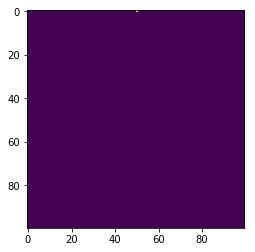

In [18]:
(framexmin, framexmax, frameymin, frameymax) = framer(x[10], y[10])
(xy, x_pixel_centers, y_pixel_centers) = pixelate(xlim, ylim, 100, np.array(x[0]), np.array(y[0]), particlem)
#print y_pixel_centers
#print xy[5]
#print convolve_fft(xy,kernel)[5]
plt.imshow(xy)
plt.show()

In [112]:
from matplotlib.colors import LogNorm

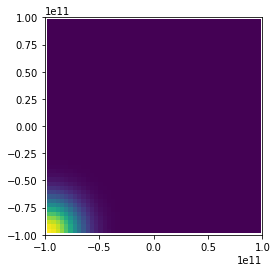

In [19]:
#fsize = 5e11
fsize = 1e11
xlim=(-fsize, fsize)
ylim=(-fsize, fsize)
n_bins = 50
pixelreplacement = 1e-5
kernel = Gaussian2DKernel(stddev=(5))

fig, ax = plt.subplots()
# ax = plt.axes()
(xy, x_pixel_centers, y_pixel_centers) = pixelate(xlim, ylim, n_bins, np.array(x[0]), np.array(y[0]), particlem)
#xy[xy == 0] = pixelreplacement
hh = convolve_fft(xy, kernel)
im=plt.imshow(np.transpose(hh),interpolation="none", origin="lower",
              extent=[x_pixel_centers[0], x_pixel_centers[-1],
                      y_pixel_centers[0], y_pixel_centers[-1]])

ax.autoscale(False)
def init():
    (xy2, x_pixel_centers, y_pixel_centers) = pixelate(xlim, ylim, n_bins, np.array(x[0]), np.array(y[0]), particlem)
    #hh, xx, yy, pp = plt.hist2d(xy[0], xy[1],bins=50)
    hh = convolve_fft(xy2, kernel)
    im.set_data(hh)
    return [im]

def animate(i):
    (xy2, x_pixel_centers, y_pixel_centers) = pixelate(xlim, ylim, n_bins, np.array(x[i]), np.array(y[i]), particlem)
    #print xy[0]
    #print xy[1]
    #hh, xx, yy, pp = plt.hist2d(xy[0], xy[1], bins=50)
    hh = convolve_fft(xy2, kernel)
    im.set_data(hh)
    return [im]

#fig = plt.figure(figsize=(8,8))
# fsize = 5e12
ax.set_xlim(-fsize, fsize)
ax.set_ylim(-fsize, fsize)
# ax = plt.axes(xlim=(-fsize, fsize), ylim=(-fsize, fsize))
# ax.set_facecolor('whitesmoke')
# ax.minorticks_on()
# ax.tick_params('both', length=8, which='major')
# ax.tick_params('both',length=3, which='minor')
# ax.set_xlabel('')
# ax.set_ylabel('')
# ax.xaxis.set_ticks_position('none')
# ax.yaxis.set_ticks_position('none')
# ax.set_xticklabels([])
# ax.set_yticklabels([])
# ax.grid(True, which='major', ls='dashed', alpha=.5)
# ax.grid(True, which='minor', ls='dashed', alpha=.15)
#ax.imshow(a,interpolation='gaussian')
rc('animation', html='html5')
anim = animation.FuncAnimation(fig, animate,
                               frames=nt_simulation, interval=60, blit=True)
anim

(array([[ 0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  1.,  1.,  1.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  2.,  4.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  2.,  0.,  0.,  3.,  3.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.,  1.,  3.,  1.,  0.,  1.,  1.],
       [ 1.,  1.,  1.,  0.,  1.,  0.,  1.,  2.,  0.,  0.],
       [ 0.,  1.,  1.,  2.,  1.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]]), array([ -1.56450883e+12,  -1.25865681e+12,  -9.52804782e+11,
        -6.46952758e+11,  -3.41100734e+11,  -3.52487098e+10,
         2.70603314e+11,   5.76455339e+11,   8.82307363e+11,
         1.18815939e+12,   1.49401141e+12]), array([ -1.39275058e+12,  -1.04128623e+12,  -6.89821880e+11,
        -3.38357529e+11,   1.31068218e+10,   3.64571173e+11,
         7.16035523e+11,   1.06749987e+12,   1.41896422e+

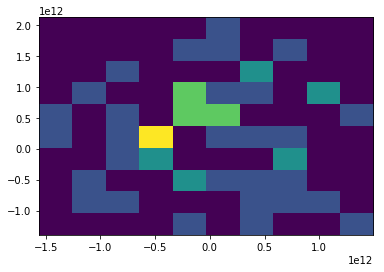

In [40]:
print plt.hist2d(x[10],y[10])

In [4]:
FFwriter = animation.FFMpegWriter()
anim.save('101bodies.mp4')

In [10]:
thing = np.array([1,2,3,4,5])
thing = np.array([np.vstack(i for i in thing)][0])
print thing

[[1]
 [2]
 [3]
 [4]
 [5]]
